# simplifying the model to mitigate overfitting

Overfitting occurs when the model is 'too complex' for the amount of training data you have available. The 'excess complexity' of the model - relative to the data - allows the model to 'tweak' its parameter values so that it 'overfits' the patterns in the data and begins to fit the statistical 'error' in the data set.

One way to mitigate model overfitting is to design the model so that it is *just complex enough* to fit the expected *patterns* in the data, removing from the model any 'excess complexity' that could be used to overfit the training data.

In the case of probabilistic modeling, the statistical model is specially crafted from expert knowledge of the particular problem domain. The structure and parameters of the model are specified directly from domain-knowledge, so there is a direct link between the model and the expected *processes* that generated the data. In these cases, it's relatively easy to 'tune' the model to match the expected patterns in the data.

Unfortunately, neural networks are *not* typically built directly from domain-knowledge. Rather, the majority of neural networks are *general purpose* approaches that can be *applied* to a wide variety of different problems in many different domains. The 'general' nature of neural networks can be a benefit in many cases, because you can use the same type of model in many different problem domains. However, it does make it more difficult to reliably *tune* the neural network model to capture the expected complexity of the data, because there is no direct link between the parameters of the neural network and the 'parameters' of the problem domain.

In general, the statistical 'complexity' of a model is related to the number of 'free parameters' in the model (also called "trainable parameters" in AI lingo). The more free parameters you have in your model, the higher the model's 'complexity'. Of course, this is a rough correlation, not absolute. But in general, reducing the number of free parameters in a model will typically reduce its complexity and mitigate its potential to 'overfit' training data.

A large amount of research effort in neural networks is focused on developing new 'types' of neurons that maintain the exceptional epxressive power of the network while simultaneously reducing the number of trainable parameters. Convolution networks, recurrent networks and multi-head attention (aka, "transformers") are all types of neurons that were designed with the explicit goal of achieving high expressivity with low parameter counts.

Without resorting to 'fancy' neuron types, we can control the 'complexity' of our neural network by changing its shape (ie, the depth of the network and the widths of its layers).

Adding neurons to a network increases the network's parameter count, which can be done by increasing either network depth or layer width. Removing neurons from the network - by removing either entire layers or reducing the width of each layer - will reduce the network's parameter count.

Of course, if you remove *too many* neurons from your network, you increase the likelihood that your model will *underfit* the training data, leading to potentially biased and unreliable results. Biases introduced by underfitting can cause very serious problems for statistical analyses.

In this notebook, we'll start with an 'overspecified' neural network that clearly overfits its training data. We'll then systematically reduce the 'complexity' of the model to reduce overfitting.

In the below code cell, we simulate a linear data set of 100 samples with 2 explanatory variables and a single response variable.

We split the data set into 60% training and 40% validation data, and we train a complex neural network for 500 epochs using a batch size of 10, stochastic gradient descent optimization and mean squared error loss.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 2s 70ms/step - loss: 1.3142 - val_loss: 1.1978
Epoch 2/500
6/6 [==============================] - 0s 14

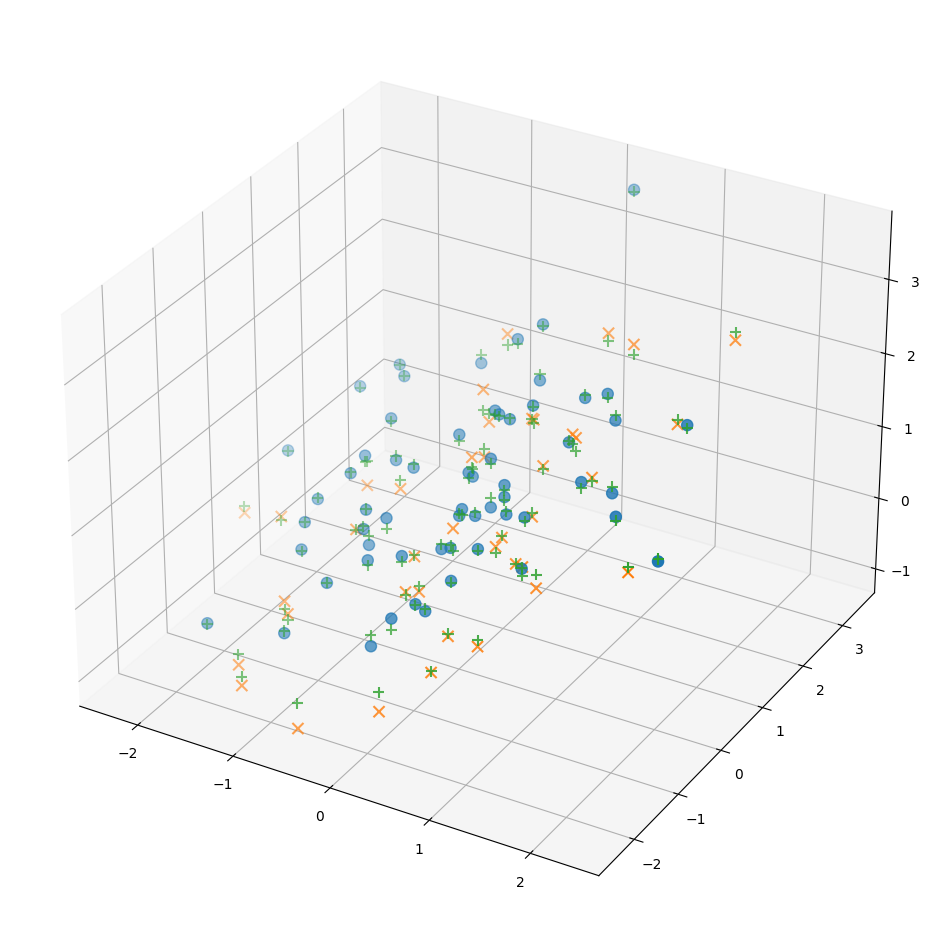

In [1]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, input_shape=[2]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

As we've seen before, this model clearly overfits it's training data, as evidenced by the final training "loss" being much less than the model's loss on the validation data ("val_loss").

Our current model has 2 hidden layers and 64 neurons ("units") in each layer (except the output layer, which must have a single neuron to match the shape of the response variable).

We could 'simplify' this model by reducing the number of hidden layers and/or by reducing the number of units in each layer.

Let's start by reducing the layer width, as it's the easiest thing to do, operationally.

The width of a layer is specified by the "units" option, which is just a number. We could manually change each:

    units=64

option to specify a smaller value, which would decrease the width of that layer.

However, we could also introduce a new python 'variable' to hold the layer width, and then use that 'variable' to specify the width of each layer in the network. In that case, we'd only need to change the *variable's* value once, rather than chaniging it for *each* layer in the network.

The following code cell implements the *same* neural network as before, but using a new python variable, that we call "n_units".

You'll notice that on line 25, we introduce the new "n_units" variable, and set its value to 64.

    n_units = 64

Then, when we add a new Dense layer to the model (lines 29,30,31), we use the "n_units" variable to specify the "units" option of the layer:

    units=n_units

Simple.

If you run the following code cell as-is, you should get the exact *same* model as in the previous code cell. The model fit will be *slightly* different, of course, due to the 'stochastic' nature of the model fitting process.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 1s 23ms/step - loss: 1.7437 - val_loss: 1.6627
Epoch 2/500
6/6 [==============================] - 0s 

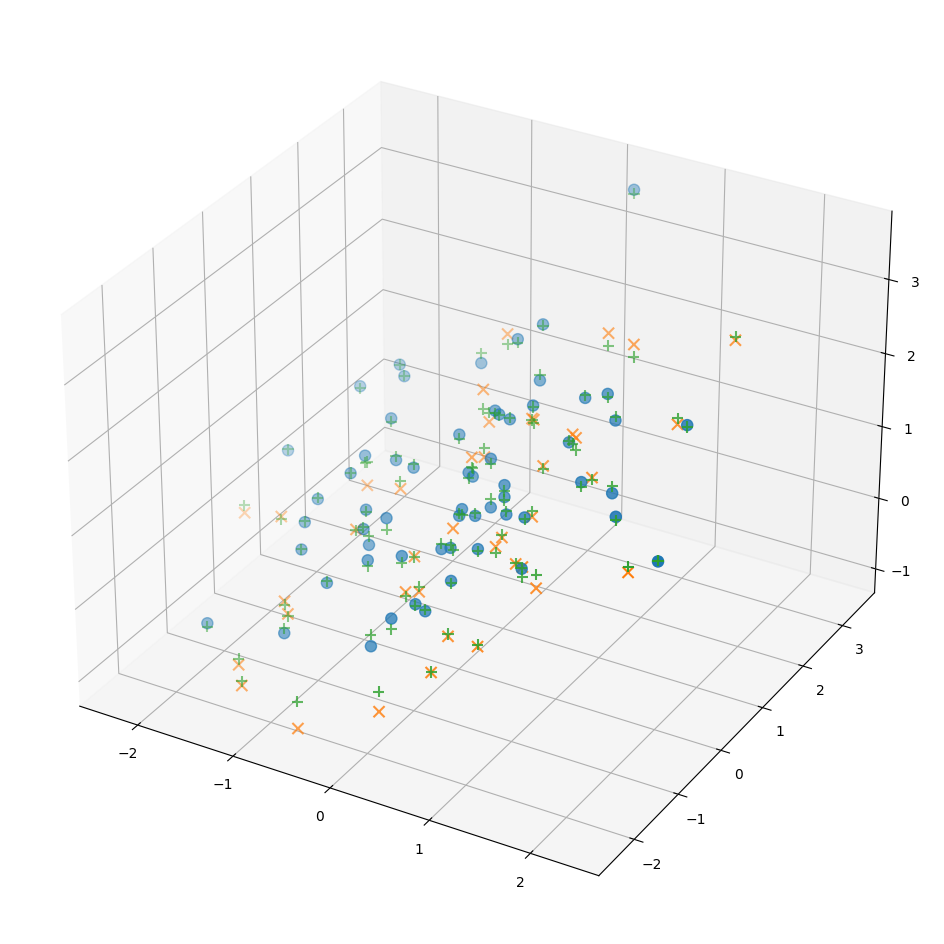

In [2]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# specify model shape
n_units = 64

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=n_units, activation=tf.keras.activations.relu, input_shape=[2]))
model.add(tf.keras.layers.Dense(units=n_units, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=n_units, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

Now, if you want to change the layer width, you just need to set "n_units" to a *different* value *once* in the code, rather than having to do it three times. This makes the code easier to maintain and more readable.

Most neural networks have layer widths that are 'powers of 2' (1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1). Historically, this can help neural network calculations better 'fit' into the GPU hardware, and sometimes trigger additional hardware speed-ups that make the calculations run faster. Given the rapid pace of GPU hardware development, it's not clear that this 'power of 2 rule' is really that important in practice.

Model development should primarily be guided by the goal of producing reliable, accurate results. Only *after* the model is performing well from a statistical perspective should you switch your focus to improving *computational* efficiency.

For now, take some time altering the "n_units" parameter in the previous code cell to implement networks of different layer widths. Observe the results of increasing or decreasing layer widths on model overfitting in this example. Can you reduce overfitting to the point where val_loss &leq; loss after training? How small must the layer width be to eliminate overfitting?

## changing network depth programmatically

Making it really easy to change the number of hidden layers in the network takes a little more work (and a python for loop), but we can use a similar approach as we did to change the network's layer width: Create a new python variable that will hold the number of hidden layers in the network, and then use that variable when the model is being built.

Of course, we could just copy-and-paste hidden layers into and out of our network, manually, but where's the fun in that?

First, we'll define a new python variable called "n_hidden_layers", and set it equal to the number of hidden layers currently in our network (which is 2):

    n_hidden_layers = 2

This is on line 26 in the following code cell.

Next, we need to *use* this variable to add the *correct number* of hidden layers to our network.

To do this, we introduce a "for loop" on line 31 of the following code cell:

    for i in range(n_hidden_layers):

The for loop specification line ends in a colon ":", telling python that the following *indented* line(s) should be executed multiple times.

How many times? The:

    range(n_hidden_layers)

part tells python that the for loop should be executed "n_hidden_layers" times.

The:

    for i in ...

part is mostly just python syntax for creating a for loop. The "i" creates a new variable that can be used inside the for loop's indented code, but we don't use it in this example.

The *indented* code following the for loop specifier (line 32 in the following code cell) will be executed *each time* through the for loop. That code adds a new hidden layer to our model:

    model.add(tf.keras.layers.Dense(units=n_units, activation=tf.keras.activations.relu))

So, each time through the for loop, we add a new Dense layer with "n_units" neurons to the Sequential model. We do this "n_hidden_layers" times, and n_hidden_layers=2, so we'll have 2 hidden layers in our network.

This should create the *same* neural network model that we had in the original code cell, which you can verify by running the following code cell and observing the model's summary output.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                192       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 1s 23ms/step - loss: 1.2291 - val_loss: 1.0733
Epoch 2/500
6/6 [==============================] - 0s 

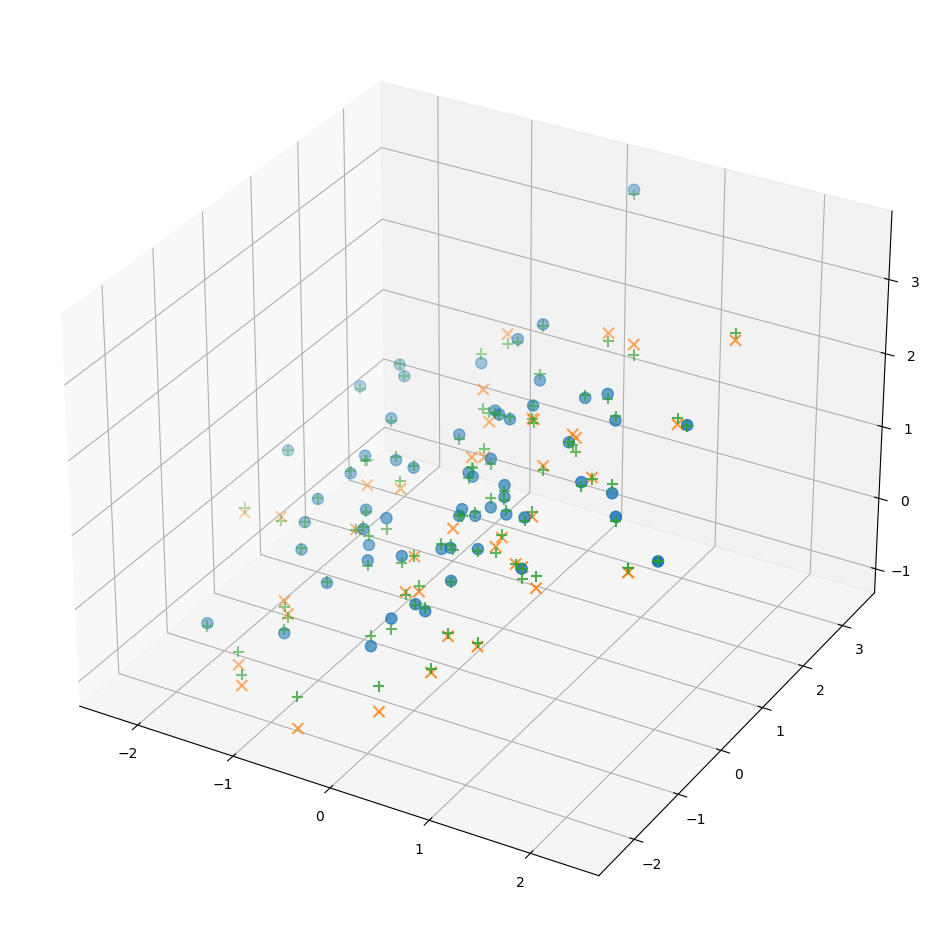

In [3]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# specify model shape
n_units = 64
n_hidden_layers = 2

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=n_units, activation=tf.keras.activations.relu, input_shape=[2]))
for i in range(n_hidden_layers):
  model.add(tf.keras.layers.Dense(units=n_units, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

Now you have 2 simple 'dials' you can tweak to 'dial in' your model's complexity.

You can change the "n_units" parameter to any integer value &ge;1, which will specify the width of the network's input layer and any hidden layers it might have.

And you can change the "n_hidden_layers" parameter to any integer value &ge;0, which will specify the number of hidden layers in your network.

Go ahead and try some various combinations of values for "n_units" and "n_hidden_layers" in the previous code cell, and observe the impact of your choices on model overfitting. Does one parameter seem to have more or less of an impact on overfitting than the other? How 'big' can you make your network before it starts to overfit the training data? Is there some *minimum* network size you need to fit these data?

'Tuning' a neural network's complexity by trial-and-error can provide you with quite a bit of intuitive insight into how various networks are likely to perform on a given data set. Over time and experience, you will start to develop more of a 'feel' for how to design an initial network for a specific problem.